<a href="https://colab.research.google.com/github/akitim/Ligand_activity_prediction_GlobalAI2022/blob/main/ligand_activity_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [1]:
!python -m pip install rdkit-pypi

     |████████████████████████████████| 20.6 MB 2.2 MB/s 


In [2]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.3 MB/s 


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.SaltRemover import SaltRemover

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

## Функции

In [4]:
def get_submission_file(clf, data):
    
    X_test = data[data['is_test']].\
        drop(['is_test', 'smiles', 'active'], axis=1)

    submission = data.loc[data['is_test'], ['smiles']].reset_index(drop=True)
    submission['Active'] = clf.predict(X_test)
    submission.columns = ['Smiles', 'Active']

    submission.to_csv('submission.csv')
    return submission

def remove_salt_ions(smiles):

    sr = SaltRemover()
    mol = Chem.MolFromSmiles(smiles)
    result, deleted = sr.StripMolWithDeleted(mol)
    
    result = Chem.MolToSmiles(result)
    deleted = list(map(Chem.MolToSmiles, deleted))

    return result, deleted

def num_of_(df, atom) -> pd.DataFrame:
    df_ = df.copy()
    df_[atom] = df_['smiles'].apply(lambda smpl: smpl.count(atom))
    return df_ 

def strp_mol(smiles):
    
    s_ = smiles
    to_clear = ['(', ')', '[', ']', '=', '-',
                '1', '2', '3', '4', '5', '6', '7', '8', '9']
    for sym in to_clear:
        s_ = s_.replace(sym, '')
    return s_

## Загружаем данные:

In [5]:
train_path = 'https://raw.githubusercontent.com/akitim/datasets/main/ligand_activity_prediction/train.csv'
test_path = 'https://raw.githubusercontent.com/akitim/datasets/main/ligand_activity_prediction/test.csv'

train = pd.read_csv(train_path)
# train = pd.read_csv('/content/train.csv')
test = pd.read_csv(test_path)
# test = pd.read_csv('/content/test.csv')

train.sample(5)

,Unnamed: 0,Smiles,Active
1146,1146,COc1ccc(Nc2nccc(NCCO)n2)cc1,False
1456,1456,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(Cn3ccc...,False
4270,4270,NC1(C(=O)N[C@@H](CCO)c2ccc(Cl)cc2)CCN(c2ncnc3[...,False
1157,1157,O=C(NC1CC1)c1cc(-c2cccs2)on1,False
5255,5255,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3c(-c4ccc(OC...,False


In [6]:
train = train.loc[:, ['Smiles', 'Active']]
train.columns = ['smiles', 'active']
train['is_test'] = False
# train['active'] = train['active'].astype('int32')

test = test.loc[:, ['Smiles']]
test['active'] = None #pd.NA().nan
test.columns = ['smiles', 'active']
test['is_test'] = True

data = pd.concat([train, test]).reset_index(drop=True)

In [7]:
data.sample(5)

,smiles,active,is_test
868,Cc1cc(C(=O)Nc2cc(Oc3ccc4nc(NC(=O)C5CC5)cn4n3)c...,False,False
3413,CCCCNc1ncc2c(-c3ccc(CN4CCN(C)CC4)cc3)cn([C@H]3...,False,False
4848,C[N+](C)(C)CCOC(N)=O.[Cl-],False,False
2714,O=C(c1c2ccccc2cc2ccccc12)N1CCC(N2CCC[C@@H](C(=...,True,False
5438,NC(=O)N1c2ccccc2CC(=O)c2ccccc21,False,False


In [8]:
train.shape, test.shape

((5557, 3), (1614, 3))

In [9]:
active_ind = train.groupby('active').groups[1]
not_active_ind = train.groupby('active').groups[0]
print(f"Active: {active_ind.size}\n\
Not active: {not_active_ind.size}")

Active: 206
Not active: 5351


## Модель 0 (random baseline)

In [10]:
# submission = test.copy()
# submission['Active'] = (np.random.rand(test.shape[0]) <= 206 / 5351)
# #(np.random.rand(test.shape[0]) <= 206 / 5351) #.astype('int32')
# test.loc[test['Active'], 'Active'].count() / test.shape[0]
# submission.to_csv('submission.csv')


## Предобработка

In [11]:
# удаляем соли
# deleted_salts = data['smiles'].apply(lambda s: remove_salt_ions(s)[1])
data['smiles'] = data['smiles'].apply(lambda s: remove_salt_ions(s)[0])

In [12]:
# deleted_salts = deleted_salts[deleted_salts.apply(lambda x: any(x) and any([el != '*' for el in x]))]
# deleted_salts[deleted_salts.apply(lambda x: len(x) > 1)]
data

,smiles,active,is_test
0,COc1ccc2[nH]cc(CCN)c2c1,False,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1,False,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False,False
...,...,...,...
7166,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,None,True
7167,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,None,True
7168,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,None,True
7169,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,None,True


In [13]:
# import re
# def remove_salt_ions(str_, ls):

#     new_str_ = str_
#     for s in ls:
#         while s in new_str_:
#             new_str_ = new_str_.replace(s, '')

#     return new_str_

# salt_ion_list = ['.[Na+]', '.[K+]', '.[Li+]', '.[Ca+2]', '.[Ba+2]', '.[Sr2+]',
#                  '.[I-]', '.[Cl-]', '.[Br-]', '.[Mg+2]', '.[Zn+2]', '.[N+]([O-])[O-]',
#                  ]

# salt_ion_mask = data['smiles'].apply(lambda m: any(a in m for a in salt_ion_list))
# data.loc[salt_ion_mask, 'smiles'] = \
#     data.loc[salt_ion_mask, 'smiles']\
#     .apply(lambda s: remove_salt_ions(s, salt_ion_list))

# data.loc[salt_ion_mask, 'smiles']
# data.loc[data['smiles'].apply(lambda m: any(a in m for a in ['.Br', 'Br.','.Cl', 'Cl.', '.I', 'I.']))]
# data.loc[data['smiles'].apply(lambda m: all(a not in m for a in ['c', 'C'])), ['smiles', 'active']]
# salt_ion_list = ['].[']

## Генерация новых признаков

In [78]:
# def num_of_(df, atom) -> pd.DataFrame:
#     df_ = df.copy()
#     df_[atom] = df_['smiles'].apply(lambda smpl: smpl.count(atom))
#     return df_ 

data['MW'] = data['smiles'].apply(lambda x:
                                  np.round(MolWt(Chem.AddHs(
                                      Chem.MolFromSmiles(x))), 1)
                                  )

atoms = ['C', 'c', 'ccccc', 'O', 'o', 'N', 'N+', 'n', 'P',
         'S', 's', 'Cl', 'Br', 'F', '(']

for a in atoms:
    data = num_of_(data, a)

data['MW+(+C+O'] =  data['MW'] + data['('] + data['C'] + data['O']
data = data.drop(['MW', '(', 'C', 'O'], axis=1)

# логарифмируем переменнные
# for col in data.drop(['smiles', 'active', 'is_test'], axis=1).columns:
#     data[col] = data[col].apply(np.log1p)

In [79]:
q = data.drop(['smiles', 'active', 'is_test'], axis=1).corr()
q[np.abs(q) > 0.5]

,c,ccccc,o,N,N+,n,P,S,s,Cl,Br,F,MW+(+C+O
c,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ccccc,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
o,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.601539
N+,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Cl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [80]:
# for col in data.drop(['smiles', 'active', 'is_test'], axis=1).columns:
#     data[col].apply(np.log1p).hist();
#     plt.title(col)
#     plt.show();
data

,smiles,active,is_test,c,ccccc,o,N,N+,n,P,S,s,Cl,Br,F,MW+(+C+O
0,COc1ccc2[nH]cc(CCN)c2c1,False,False,8,0,0,1,0,1,0,0,0,0,0,0,195.2
1,CCCN1CCC[C@H](c2cccc(O)c2)C1,False,False,6,0,0,1,0,0,0,0,0,0,0,0,230.3
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False,False,14,1,0,3,0,2,0,1,0,0,0,0,427.5
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False,False,23,0,0,2,0,1,0,0,0,0,0,1,454.5
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False,False,19,1,0,1,0,2,0,0,0,0,0,1,334.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7166,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,None,True,6,0,0,3,0,0,0,2,0,1,0,0,407.9
7167,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,None,True,11,0,0,3,0,1,0,1,0,0,0,0,361.4
7168,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,None,True,0,0,0,0,0,0,0,0,0,0,0,0,469.6
7169,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,None,True,16,0,0,2,0,2,0,0,0,0,0,0,330.4


## Логрегрессия и случайный лес

In [81]:
RND_SEED = 42

# стандартизируем ВСЕ данные, опираясь на параметры тренировочной выборки
# меняем data!!!

# std_scaler = StandardScaler()
# std_scaler.fit(data[~data['is_test']]
#                .drop(['is_test', 'smiles', 'active'], axis=1))

# X_total = data.drop(['is_test', 'smiles', 'active'], axis=1)
# X_total.loc[:,:] = std_scaler.transform(X_total)
# data.loc[:, ~data.columns.isin(['is_test', 'smiles', 'active'])] = X_total

# разбиваем датасет на тренировку и валидацию
X = data[~data['is_test']].drop(['is_test', 'smiles', 'active'], axis=1)
y = data.loc[~data['is_test'], 'active'].astype('int32')

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=RND_SEED)

In [82]:
RND_SEED = 142

lrgr = LogisticRegression(random_state=RND_SEED,
                          n_jobs=-1, 
                          class_weight='balanced',
                          max_iter=500)
lrgr.fit(X_train, y_train)
y_pred_lrgr = lrgr.predict(X_val)

# y_pred_lrgr = ~y_pred_lrgr.astype(bool)
f1_lrgr = f1_score(y_val, y_pred_lrgr)

rfc = RandomForestClassifier(n_estimators=1000, criterion="gini",
                             max_depth=100, min_samples_leaf=4,
                             min_samples_split=2,
                             max_features=None, bootstrap=True,
                             n_jobs=-1, random_state=RND_SEED,
                             class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_val)
# y_pred_rfc = ~y_pred_rfc.astype(bool)

f1_rfc = f1_score(y_val, y_pred_rfc)
f1_lrgr, f1_rfc

(0.11031175059952039, 0.18918918918918917)

In [83]:
# оценка при разных сидах ГСЧ
f1_ = []
for rnd in np.random.randint(1, 100000, 10):
    rfc = RandomForestClassifier(n_estimators=1000, criterion="gini",
                             max_depth=100, min_samples_leaf=4,
                             min_samples_split=2,
                             max_features=None, bootstrap=True,
                             n_jobs=-1, random_state=rnd,
                             class_weight='balanced')
    rfc.fit(X_train, y_train)
    y_pred_rfc = rfc.predict(X_val)
    f1_ += [f1_score(y_val, y_pred_rfc)]
np.mean(f1_)

0.18946908552388003

## Submission RFC & LogRegression

In [ ]:
get_submission_file(rfc, data)

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,0
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,0
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,1
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,0
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,0
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,0
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,0
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,0
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,0


In [ ]:
test

,smiles,active,is_test
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,None,True
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,None,True
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,None,True
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,None,True
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,None,True
...,...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,None,True
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,None,True
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,None,True
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,None,True


In [ ]:
# #(np.random.rand(test.shape[0]) <= 206 / 5351) #.astype('int32')
# test.loc[test['Active'], 'Active'].count() / test.shape[0]
# submission.to_csv('submission.csv')

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,False
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,True
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,False
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,False
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,True
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,True
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,True
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,False
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,True


## Логрегрессия с кросс-валидацией

In [21]:
lrgr_cv = LogisticRegressionCV(Cs=10, #np.logspace(-8, 3, endpoint= True),
                               cv=5, # cv=int - Stratified Cross-Validation w/10 folds
                               scoring='f1',
                               solver='liblinear',
                               penalty='l2',
                               max_iter=500,
                               class_weight='balanced',
                               random_state=RND_SEED, 
                            #    l1_ratios=np.arange(0, 1.2, 0.3)
);
lrgr_cv.fit(X, y)


LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=500,
                     random_state=42, scoring='f1', solver='liblinear')

Max F1 = 0.11255935884492427


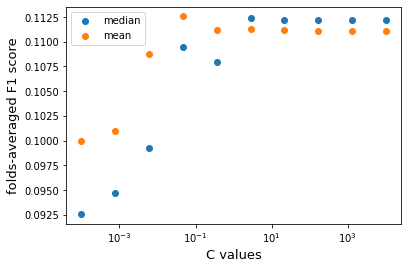

In [22]:
lrgr_cv.scores_[True].shape
lrgr_cv.get_params()

# print(lrgr_cv.Cs_)
# print(lrgr_cv.scores_[True].mean(axis=0))

plt.scatter(lrgr_cv.Cs_, np.median(lrgr_cv.scores_[True], axis=0));
plt.scatter(lrgr_cv.Cs_, np.mean(lrgr_cv.scores_[True], axis=0));
plt.xlabel('C values', fontsize=13)
plt.ylabel('folds-averaged F1 score', fontsize=13)
plt.xscale('log');
plt.legend(['median', 'mean'], loc='best');

print( f'Max F1 = {np.mean(lrgr_cv.scores_[True], axis=0).max()}')

In [20]:
y_p = lrgr_cv.predict(X_val)
f1_score(y_val, y_p)

0.0925925925925926

##Catboost с кросс-валидацией

In [84]:
from catboost import CatBoostClassifier, Pool, FeaturesData

RND_SEED = 42

# разбиваем датасет на тренировку и валидацию
features_to_drop = [
                    'smiles',
                    'is_test', 'active'
]

X_cb = data[~data['is_test']].drop(features_to_drop, axis=1)
y_cb = data.loc[~data['is_test'], 'active']

X_cb_train, X_cb_val, y_cb_train, y_cb_val = train_test_split(
    X_cb, y_cb, test_size=0.2, random_state=RND_SEED
)

# X_cb_train_fd= Pool(FeaturesData(
#     num_feature_data = X_cb_train['MW'].values.reshape(-1, 1).astype(np.float32),
#     cat_feature_data = X_cb_train.drop(['MW', 'smiles'], axis=1).values.astype(str),
#     num_feature_names = ['MW'],
#     cat_feature_names = X_cb_train.drop(['MW', 'smiles'], axis=1).columns
# ))

# X_cb_val_pool = Pool(FeaturesData(
#     num_feature_data = X_cb_val['MW'].values.reshape(-1, 1).astype(np.float32),
#     cat_feature_data = X_cb_val.drop(['MW', 'smiles'], axis=1).values.astype(str),
#     num_feature_names = ['MW'],
#     cat_feature_names = X_cb_val.drop(['MW', 'smiles'], axis=1).columns
# ))

cb_clf = CatBoostClassifier(
    loss_function=None,
    eval_metric='F1',
    learning_rate=0.5,
    verbose=False,
    # text_processing=text_processing_options,
    random_seed=RND_SEED
)

cb_clf.fit(X_cb_train, y_cb_train.astype(str)
        #    text_features=['smiles']
)
y_pred_cb = cb_clf.predict(X_cb_val)
y_pred_cb = np.asarray([y == 'True' for y in y_pred_cb])

f1_score(y_cb_val.astype('int8'), (y_pred_cb).astype('int8'))
# X_cb_train_pool = 

0.25806451612903225

In [ ]:
# get_submission_file(cb_clf, data)

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,False
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,False
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,True
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,False
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,False
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,False
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,False
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,False
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,False


In [ ]:
from catboost import cv

train_pool = Pool(
    data=X_cb,
    label=y_cb.astype(str),
    has_header=True
)

params = {
    'loss_function': 'Logloss',
    # 'iterations': 100,
    'custom_loss': 'F1',
    'learning_rate': 0.5,
    'random_state': RND_SEED
}

cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=RND_SEED,
    plot=False,
    stratified=True,
    verbose=False
)


---
---
---
ИДЕИ
---
---

### Дескрипторы из RDkit

COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cccnc5)CC4)c3n2)cc1
Unknown


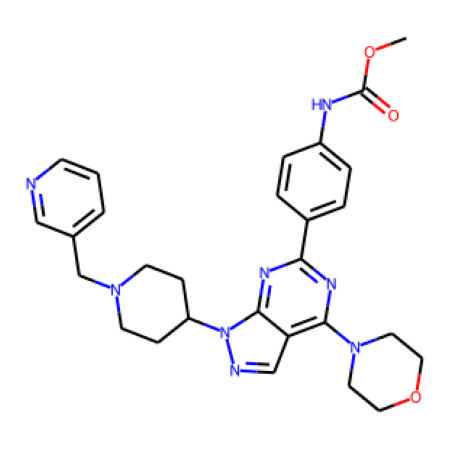

In [88]:
smpl_ind = 5557
smpl = data.loc[smpl_ind, 'smiles']

if_active = 'Active' if data.loc[smpl_ind, 'active'] \
                    else ('Not active' if smpl_ind < 5556 else 'Unknown')

mol = Chem.MolFromSmiles(smpl)
im = Chem.Draw.MolToImage(mol)
print(f'{smpl}\n{if_active}')
plt.figure(figsize = (8, 8))
axs = plt.axes(frameon=True)
axs.imshow(im)
axs.axis('off');

In [101]:
import rdkit.ML as ML
from rdkit.Chem import Descriptors as dscr, Descriptors3D as dscr3D
# rdkit.Chem.Descriptors3D as 
import rdkit.ML.Descriptors.MoleculeDescriptors as moldscr
from rdkit.Chem import AllChem

mol = Chem.MolFromSmiles(smpl)
# dscr.(mol)
descr_ls = ['BalabanJ', 'TPSA', 'NHOHCount', 'NumHAcceptors',
            'NumHDonors', 'BertzCT', 'Ipc', 'Chi0',
            'RingCount' ,'NumAromaticRings', 'NumAromaticHeterocycles', 
            '']
mdc = moldscr.MolecularDescriptorCalculator(descr_ls)
mdc.CalcDescriptors(mol)


mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
# dscr3D.RadiusOfGyration(mol)
dscr3D.rdMolDescriptors.CalcMORSE(mol)

224

### Визуализация молекулы

In [ ]:
# 616                        O1[As]2O[As]3O[As]1O[As](O2)O3
# 1144                                        O=N[O-].[Na+]
# 1172    O=[Mg].O=[Mg].O=[Mg].O=[Si]=O.O=[Si]=O.O=[Si]=...
# 2569                                            [I-].[K+]
# 2858                         O=P([O-])([O-])F.[Na+].[Na+]
# 6264                                          NS(N)(=O)=O

# 616          O1[As]2O[As]3O[As]1O[As](O2)O3
# 915          CC(=O)Nc1cc([As](=O)(O)O)ccc1O
# 5864     O=[N+]([O-])c1ccc([As](=O)(O)O)cc1
# 6562    O=[N+]([O-])c1cc([As](=O)(O)O)ccc1O
# 6761                Nc1ccc([As](=O)(O)O)cc1

CCC(COC(=O)c1cc(OC)c(OC)c(OC)c1)(c1ccccc1)N(C)C
Unknown


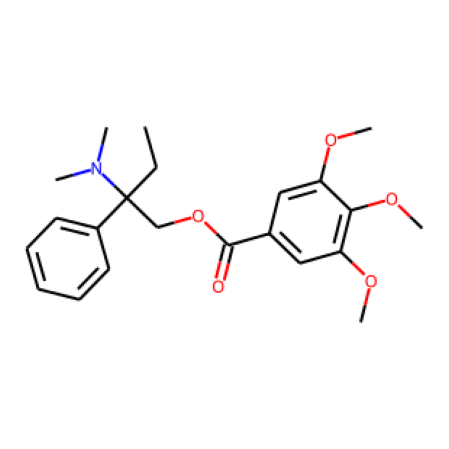

In [ ]:
# smpl = train['smiles'][134]
smpl_ind = 7084
smpl = data.loc[smpl_ind, 'smiles']

# smpl = 'C(-c6cnc7ccccc7c6)'
if_active = 'Active' if data.loc[smpl_ind, 'active'] \
                    else ('Not active' if smpl_ind < 5556 else 'Unknown')

mol = Chem.MolFromSmiles(smpl)
im = Chem.Draw.MolToImage(mol)
print(f'{smpl}\n{if_active}')
plt.figure(figsize = (8, 8))
axs = plt.axes(frameon=True)
axs.imshow(im)
axs.axis('off');

### Визуализируем группу молекул:

IndexError: ignored

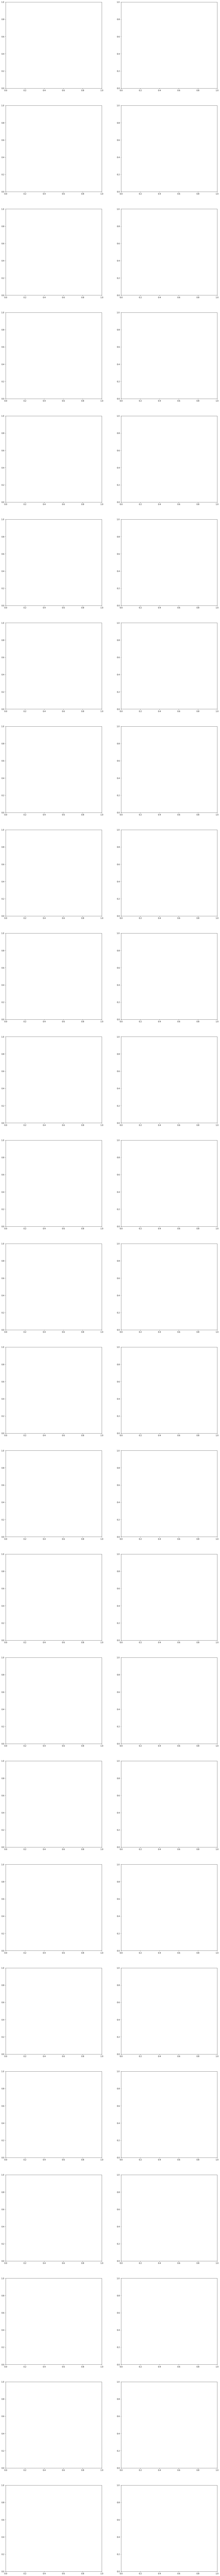

In [ ]:
# samples = train.iloc[active_ind, :]['smiles'].values
start_n = 0
stop_n = 50
n_to_plot = stop_n - start_n
n_plot_rows = n_to_plot // 2 + n_to_plot % 2
# mask_ = data['smiles'].apply(lambda m: any(a in m for a in ['.']))
# samples = data.loc[mask_, ['smiles']][start_n:stop_n]

samples = pd.DataFrame(deleted_salts[start_n:stop_n])

fig, axs = plt.subplots(n_plot_rows, 2, figsize=(20, n_to_plot*5))
axs = (ax for ax in axs.ravel())

for ind in samples.index:
    ax_curr = next(axs)
    smpl = samples.loc[ind, 'smiles']
    mol = Chem.MolFromSmiles(smpl)
    im = Chem.Draw.MolToImage(mol)
    print(f'{ind}) {smpl}')
    # plt.figure(figsize = (3, 3))
    # axs(i) = plt.axes(frameon=True)
    ax_curr.imshow(im)
    ax_curr.set_title(f'{ind}: {smpl}');
    ax_curr.axis('off');

# # удаляем пустой график
# if n_to_plot % 2:
#     ax_curr = next(axs)
#     im = Chem.Draw.MolToImage(Chem.MolFromSmiles('C1CCC1'))
#     ax_curr.imshow(im)
#     fig.delaxes(ax_curr)    
# for ax in axs:    
#     if not(ax.has_data()):
#         fig.delaxes(ax_curr)

In [ ]:
# (data.loc[smpl_ind, 'active'])
mask_ = data['smiles'].apply(lambda m: any(a in m for a in ['.Br', 'Br.','.Cl', 'Cl.', '.I', 'I.']))
samples = data.loc[mask_, 'smiles']
samples.iloc[68]

'CCOC(=O)OC(C)OC(=O)[C@@H]1N2C(=O)[C@@H](NC(=O)[C@H](N)c3ccccc3)[C@H]2SC1(C)C.Cl'

In [ ]:
from rdkit.Chem.SaltRemover import SaltRemover

remover = SaltRemover()
mol = Chem.MolFromSmiles('F.C[N+]1(C)C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2.O=[N+]([O-])[O-].O=C(O)C(=O)O')
res, deleted = remover.StripMolWithDeleted(mol)
# Chem.MolToSmiles(delete[1]), Chem.MolToSmiles(res.])
Chem.MolToSmiles(res)
# deleted[0]

'C[N+]1(C)C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2.F'

### Оцениваем эффект на F1-score от замены y_pred на ~y_pred

In [ ]:
# from sklearn.metrics import f1_score
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# n_sample = 1600
# y_true = np.random.rand(n_sample) >= 0.5
# y_pred = y_true.copy()

# f1 = []
# f1_not = []

# for i in range(3000):
#     ind = np.random.randint(n_sample)
#     if y_pred[ind] == y_true[ind]:
#         y_pred[ind] = not(y_pred[ind])

#     f1 += [f1_score(y_true, y_pred)]
#     f1_not += [f1_score(y_true, ~y_pred)]
   
# # plt.hist(y_true.astype(int));

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.scatter(f1, f1_not);
# plt.xlabel('False F1', fontsize=15);
# plt.ylabel('True F1', fontsize=15);
# plt.plot([0, 1], [1, 0],);

In [ ]:
# mol = Chem.MolFromSmiles('CNNc1ccc(C(O)c2ccccc2)c(O)c1')
# mol = Chem.MolFromSmiles('Nc1nc(O)c2c(n1)NCC(CNc1ccc(C(=O)N[C@@H](CCC(=O)[O-])C(=O)[O-])cc1)N2C=O.[Ca+2]')
# im = Chem.Draw.MolToImage(mol)

# plt.figure(figsize = (10, 10))
# ax = plt.axes(frameon=True)
# ax.imshow(im)
# ax.axis('off');